## Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

## Function for plotting districts 

In [2]:
def plot_district(districtId, title=None):
    district_data = all_data[all_data.districtId == districtId].copy()
    district_name = district_data.district_name.iat[0] if title is None else title
    lockdown_weeks = district_data.loc[district_data.active_lockdown,'week_no'].agg(['min','max'])
    summer_weeks = district_data.loc[district_data.summer_vac,'week_no'].agg(['min','max'])
    
    x= district_data.week_no
    y1 = district_data.AnzahlFall_cumul
    y2 = district_data.target
    y3 = district_data.target_predicted

    fig, ax1 = plt.subplots()    
    
    plt.axvspan(*lockdown_weeks, color='lightgray')
    plt.axvspan(*summer_weeks, color='lightgray')

    color1 = 'gray'
    ax1.set_xlabel('week')
    ax1.set_ylabel('Cumulated Cases', color = color1)
    ax1.plot(x,y1, color = color1,marker='o')
    ax1.tick_params(axis='y', color=color1)
    ax1.set_xlim(x.min(),x.max())
    ax1.set_title(district_name + '\nDashed line - prediction; solid line - observed')

    ax2 = ax1.twinx()
    color2 = 'k'
    ax2.set_ylabel('Weekly Log-R0', color = color2)
    ax2.plot(x, y2, color = color2)
    ax2.plot(x, y3, color = color2, linestyle='--')
    ax2.fill_between(x, y2, y3, where=y3 >= y2,alpha=.6, facecolor='green', interpolate=True)
    ax2.fill_between(x, y2, y3, where=y3 <= y2,alpha=.6, facecolor='red', interpolate=True)
    ax2.tick_params(axis='y', labelcolor = color2)
    ax2.grid(None)

    fig.tight_layout()
    
        
    plt.show()

## Data prep 

Read in data export from 05 Notebook

In [3]:
all_data = pd.read_csv('all_data.csv')

Get Bundesland from first digits of the districtId:

In [4]:
all_data['Bundesland'] = all_data.districtId // 1000

Add Boolean mask columns for active lockdown and summer vacation to panel dataset.

In [5]:
#THESE ARE DIFFERENT FROM WHAT I THOUGHT:
#They are the first COMPLETE vacation week
# ferien_dict = {8:31,#keys: Bundesland
#                9:31,#values: Calendar week of the first day of
#                11:27,#summer vacation in that Bundesland
#                12:27,
#                4:25,
#                2:27,
#                6:28,
#                13:26,
#                3:30,
#                5:27,
#                7:28,
#                10:28,
#                14:30,
#                15:30,
#                1:27,
#                16:30}
ferien_dict = {1:27,
              2:26,
              3:29,
              4:29,
              5:27,
              6:28,
              7:28,
              8:31,
              9:31,
              10:28,
              11:26,
              12:26,
              13:26,
              14:30,
              15:29,
              16:30}

summer_vac_df = pd.DataFrame()

for bl,start in ferien_dict.items():
    VACATION_INTERVAL_LENGTH = 7
    #six weeks of vacation plus one extra week for all travel returnees to get tested    
    ferien = [start+x for x in range(0,VACATION_INTERVAL_LENGTH)]
    bl_data = all_data.loc[all_data.Bundesland==bl,['districtId','week_no']].copy()
    bl_data['summer_vac'] = bl_data.week_no.isin(ferien)
    summer_vac_df = summer_vac_df.append(bl_data)
    
all_data = pd.merge(all_data, summer_vac_df, how='outer')

LOCKDOWN_BEGIN, LOCKDOWN_END = 12, 21

all_data['active_lockdown'] = all_data.week_no.between(LOCKDOWN_BEGIN, LOCKDOWN_END, inclusive = True)
    


Average the deviances per district, during the respective intervals

In [6]:
lockdown = all_data[all_data.active_lockdown].groupby('districtId')['deviance'].mean().reset_index()
summer = all_data[all_data.summer_vac].groupby('districtId')['deviance'].mean().reset_index()
deviance_merge = pd.merge(lockdown, summer,
                      on='districtId',how='outer',
                      suffixes=('_lockdown','_summer'))

Get structural factors for peer group assignment

In [7]:
structural = all_data[['districtId','district_name','rur_z','ses_z']].drop_duplicates()
deviance_df = deviance_merge.merge(structural).set_index('districtId')

Next, for each district, assign all districts within a distance of 1 SD in the RUR-SES space as its peers. Then for both lockdown and summer vacation aggregates, calculate the center district's z-score relative to its peer group. This will be the final score by which we prioritize our PD

In [8]:
deviance_z_df = pd.DataFrame()
scaler = StandardScaler()

for i in deviance_df.index:#for each district
    center_rur = deviance_df.rur_z.at[i]#get its 'coordinates' in Ruralness-Socioeconomic Space
    center_ses = deviance_df.ses_z.at[i]
    #get Euclidean distance of all districts to the current district:
    distances = np.sqrt((deviance_df.rur_z - center_rur)**2 + (deviance_df.ses_z - center_ses)**2)
    peers_df = deviance_df[distances <= 1].copy()#all districts within one SD are part of peer group
    n_peer_kernel = peers_df.shape[0]#how many districts (including the center one) are in the peer group?
    output_dict = {'districtId':i,
                  'n_peer_kernel':n_peer_kernel}
    for t in ['lockdown','summer']:
        var_name = t + '_z'#variable name
        #get z-standardized scores for all districts in the peer group:
        peers_df[var_name] = scaler.fit_transform(peers_df['deviance_' + t].values.reshape(-1,1))
        #add the center district's z-score to output:
        output_dict[var_name] = peers_df[var_name].at[i]
        #perform test for normal distribution, except when there are not enough peers:
        output_dict['shapiro_'+var_name] = shapiro(peers_df[var_name])[1] if n_peer_kernel > 2 else np.nan
        
        
    deviance_z_df = deviance_z_df.append(output_dict, ignore_index=True)
       

In [9]:
deviance_df = pd.merge(deviance_df.reset_index(),deviance_z_df)

For validity checking, we also include the worst and median performers for each deviance:

In [10]:
def get_relevant_districts(var, n_best=3):
    sort = deviance_df.sort_values(var, ascending=False)
    n = sort.shape[0]
    
    top_x = []
    for i in range(n_best):
        top_x.append(sort.districtId.iat[i])
    
    median = sort.districtId.iat[n//2]    
    worst = sort.districtId.iat[n-1]
    
    return top_x, median, worst

In [11]:
ld_best, ld_median, ld_worst = get_relevant_districts('lockdown_z')
su_best, su_median, su_worst = get_relevant_districts('summer_z')

Lockdown Top 3:

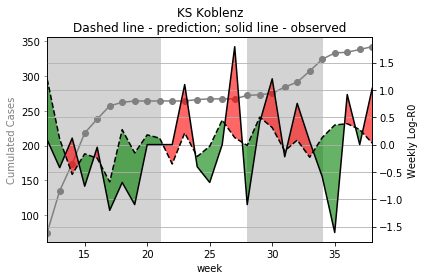

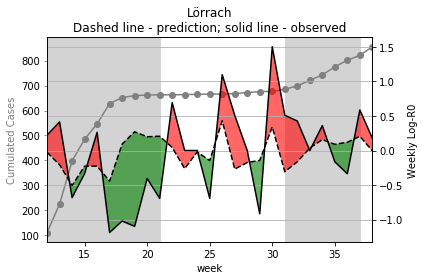

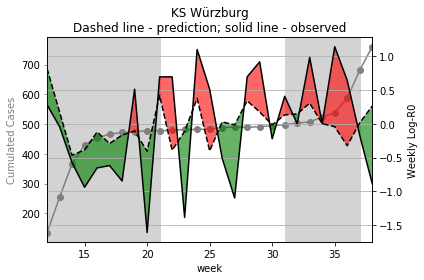

In [12]:
for d in ld_best:
    plot_district(d)

Summer Top 3:

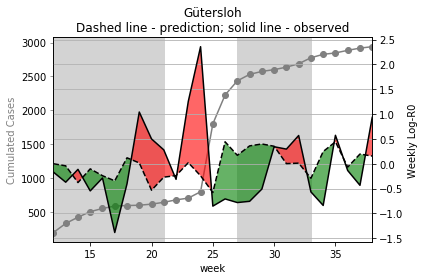

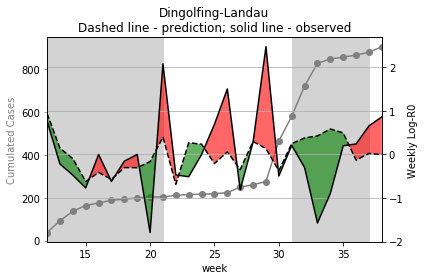

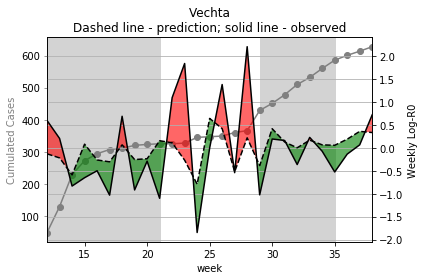

In [13]:
for d in su_best:
    plot_district(d)

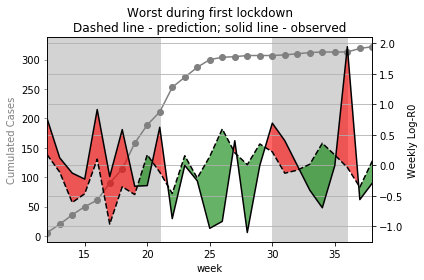

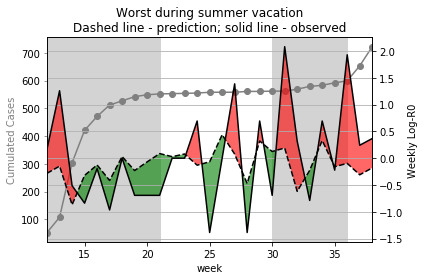

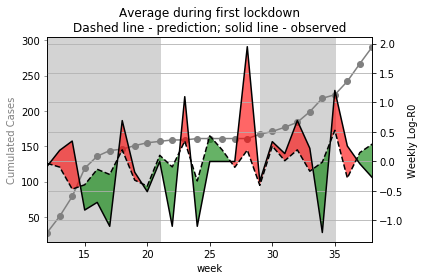

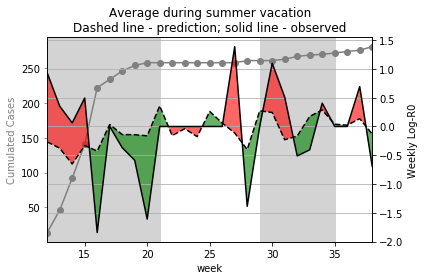

In [14]:
plot_district(ld_worst, 'Worst during first lockdown')
plot_district(su_worst, 'Worst during summer vacation')
plot_district(ld_median, 'Average during first lockdown')
plot_district(su_median, 'Average during summer vacation')

In [15]:
deviance_df['is_lockdown_pd'] = deviance_df.districtId.isin(ld_best)
deviance_df['is_summer_pd'] = deviance_df.districtId.isin(su_best)
deviance_df['lockdown_rank'] = deviance_df.lockdown_z.rank(ascending=False)
deviance_df['summer_rank'] = deviance_df.summer_z.rank(ascending=False)


In [16]:
deviance_df.to_csv('deviance_df.csv',index=False)
all_data.to_csv('all_data_with_intervals.csv',index=False)

Correlation between lockdown and summer scores:-0.10


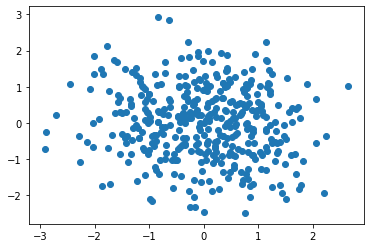

In [17]:
print('Correlation between lockdown and summer scores:{:.2f}'.format(np.corrcoef(deviance_df.lockdown_z, deviance_df.summer_z)[1,0]))
plt.scatter(deviance_df.lockdown_z, deviance_df.summer_z)

___________________________________________________________________________

Checking the normality assumption needed for z-score validity:

In [18]:
# for c in ['shap_lockdown_z','shap_summer_z']:
#     print(c)
#     deviance_df[c].hist()
#     plt.show()
#     print('Share non-normal:',np.mean(deviance_df[c]<.05))

OLD: Defining PD's with a Cut-Off:

In [19]:
# CUT_OFF = 2.326

In [20]:
# NORMAL_ONLY = False

# lockdown_pd = deviance_df[deviance_df.lockdown_z >= CUT_OFF].sort_values('lockdown_z',ascending=False)
# summer_pd = deviance_df[deviance_df.summer_z >= CUT_OFF].sort_values('summer_z',ascending=False)

# if NORMAL_ONLY:
#     lockdown_pd = lockdown_pd[lockdown_pd.shap_lockdown_z>=.05]
#     summer_pd = summer_pd[summer_pd.shap_lockdown_z>=.05]

For the lockdown deviance, the comparison within peers did not change the best one, but the remainder of the top 5:

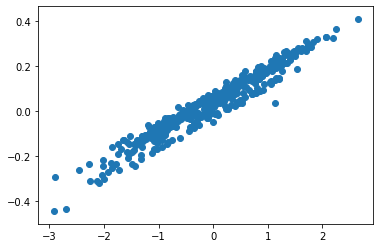

In [21]:
plt.scatter(deviance_df['lockdown_z'],deviance_df['deviance_lockdown'])

For the summer, the top 5 is ordered differently when doing peer comparison:

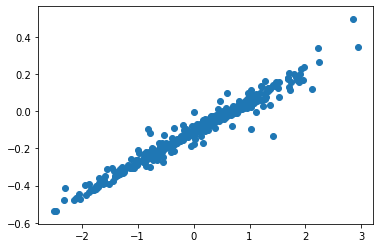

In [22]:
plt.scatter(deviance_df['summer_z'],deviance_df['deviance_summer'])